In [1]:
from scipy.optimize import curve_fit
import scipy
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile
import pims
#import cv2
from PIL import Image
import numpy as np
import matplotlib
matplotlib.use("agg")
%matplotlib inline
import matplotlib.animation as animation
import fnmatch
import os, sys
import trackpy as tp
from copy import deepcopy
from IPython.display import clear_output
from ipywidgets import interact
from nptdms import TdmsFile # this library contains the actual TDMS loading parts
import pandas as pd
from scipy import stats
import copy

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
Tracked_particles = pd.read_csv('Tracked_particles.csv')

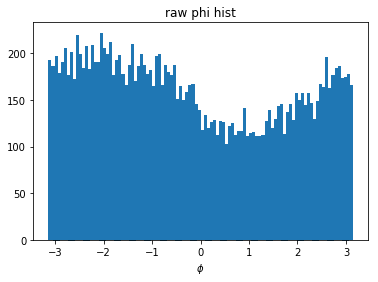

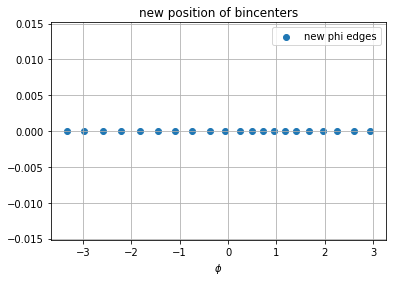

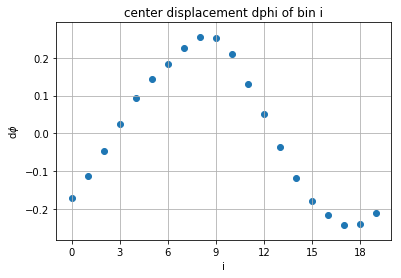

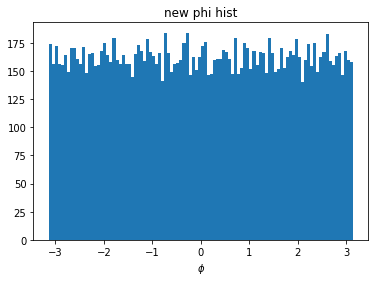

In [8]:
def Phi_calib(phi_list,TryToLoad=False,show=True):
    binN = 20  # the number of bins used for calibration, medium sized value is good
    d_0 = 2*np.pi/binN
    H_o, edges = np.histogram(phi_list,bins = np.linspace(-np.pi,np.pi,binN+1),density=True)
    phi_mids = edges[:-1] + 0.5*(edges[1]-edges[0])
    h_0 = np.mean(H_o)
    
    def Calc_new_phi_mids(phi_mids_old,d_new_list,h):
        phi_mids_new = np.zeros_like(phi_mids_old)
        phi_mids_new[0] = h - np.pi + 1/2*d_new_list[0]
        for i in range(1,len(phi_mids_new)):
            phi_mids_new[i] = phi_mids_new[i-1] + 0.5*(d_new_list[i-1]+ d_new_list[i])
        return phi_mids_new
    def Calc_sigma_dphi(h):
        dphi_list = -phi_mids + Calc_new_phi_mids(phi_mids,d_list,h)
        #dphi_list[dphi_list>np.pi] += -2*np.pi
        #dphi_list[dphi_list<-np.pi] += 2*np.pi
        #sigma = np.var(dphi_list)
        sigma = np.sum(dphi_list**2)
        return sigma
    if TryToLoad:
        try:
            params = np.load('phi_calib_params.npy')
            h_min = params['h_min']
            a_list = params['a_list']
            d_list = d_0/a_list
            Trig = False
        except FileNotFoundError:
            Trig = True
    else:
        Trig = True
    if Trig:
        a_list = h_0/H_o
        d_list = d_0/a_list
        from scipy.optimize import fmin
        #------Notes-----fmin---------------------------------------
        #-----
        #Uses a Nelder-Mead simplex algorithm to find the minimum of function of
        #one or more variables.

        #This algorithm has a long history of successful use in applications.
        #But it will usually be slower than an algorithm that uses first or
        #second derivative information. In practice it can have poor
        #performance in high-dimensional problems and is not robust to
        #minimizing complicated functions. Additionally, there currently is no
        #complete theory describing when the algorithm will successfully
        #converge to the minimum, or how fast it will if it does. Both the ftol and
        #xtol criteria must be met for convergence.
        #References
        #----------
        #.. [1] Nelder, J.A. and Mead, R. (1965), "A simplex method for function
        #       minimization", The Computer Journal, 7, pp. 308-313

        #.. [2] Wright, M.H. (1996), "Direct Search Methods: Once Scorned, Now
        #       Respectable", in Numerical Analysis 1995, Proceedings of the
        #       1995 Dundee Biennial Conference in Numerical Analysis, D.F.
        #       Griffiths and G.A. Watson (Eds.), Addison Wesley Longman,
        #       Harlow, UK, pp. 191-208.
        #------------------------------------------------------------
        h_min = float(fmin(np.vectorize(Calc_sigma_dphi),0,disp=0))
        #print('h_min = ',h_min)
    
    
    new_phi_mids = Calc_new_phi_mids(phi_mids,d_list,h_min)
    #dphi_mids = new_phi_mids-phi_mids
    new_phi_edges = list(new_phi_mids - 0.5*d_list)
    new_phi_edges.append(new_phi_edges[-1]+d_list[-1])
    
    if show:
        plt.figure()
        plt.hist(phi_list,bins=100)
        plt.title('raw phi hist')
        plt.scatter(phi_mids,H_o)
        plt.xlabel('$\phi$')
        plt.ylim(ymin = 0)
        plt.show()
    
    
    ## the picture says it all
    if show:
        plt.figure()
        plt.scatter(new_phi_edges,np.zeros(len(new_phi_edges)),label='new phi edges')
        plt.title('new position of bincenters')
        plt.grid()
        plt.legend()
        plt.xlabel('$\phi$')
        plt.savefig('new_phi_bin_while_calibating')
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        dphi_list = -phi_mids + Calc_new_phi_mids(phi_mids,d_list,h_min)
        plt.scatter(range(len(dphi_list)),dphi_list,label='center displacement dphi of bin i')
        plt.title('center displacement dphi of bin i')
        plt.xlabel('i')
        plt.ylabel('d$\phi$')
        plt.grid()
        from matplotlib.ticker import MaxNLocator
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # show integer ticks
        plt.show()  
        
    #print(np.max(new_phi_edges)-np.min(new_phi_edges)-np.max(edges)+np.min(edges))
    #print(np.array(new_phi_edges))
    
    # now calculate the new phis
    new_phis = np.zeros(len(phi_list))
    for i in range(len(new_phi_mids)):
        #following: phi_tilde_i = phi_mid_new + (phi - phi_mid_old)d_i/d_0
        indis = (phi_list>=phi_mids[i]-d_0/2)&(phi_list<=phi_mids[i]+d_0/2)
        new_phis[indis] = new_phi_mids[i] + (phi_list[indis]-phi_mids[i])*d_list[i]/d_0
        #new_phis[indis] = phi_list[indis] + (phi_mids[i]-phi_list[indis])*(1-d_list[i]/d_0) + dphi_mids[i]
    new_phis[new_phis<-np.pi] += 2*np.pi
    new_phis[new_phis>np.pi] += -2*np.pi
    
    
    
    if show:
        H_o_new, edges = np.histogram(new_phis,bins = np.linspace(-np.pi,np.pi,binN+1),density=True)
        plt.figure()
        plt.title('new phi hist')
        plt.hist(new_phis,bins=100)
        plt.xlabel('$\phi$')
        plt.show()
    
    
    return new_phis
new_phi_list = Phi_calib(np.array(Tracked_particles.phi_raw),show=True)